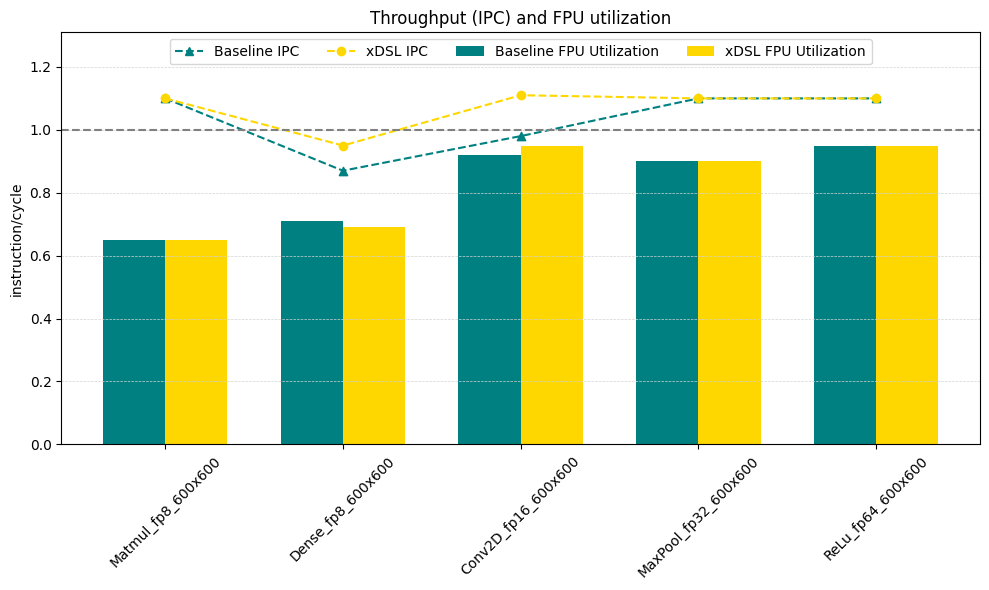

In [27]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Benchmark name, class, data type, total_ipc (inst/cycle), fpss_fpu_occupancy (inst/cycle)
TESTDATA = """
name, class, dtype, total_ipc, fpss_fpu_occupancy
Matmul_fp8_600x600, baseline, fp8,  0.98, 0.92
Matmul_fp8_600x600, xdsl, fp8,  1.11, 0.95
Dense_fp8_600x600, baseline, fp8,  0.87, 0.71
Dense_fp8_600x600, xdsl, fp8,  0.95, 0.69
Conv2D_fp16_600x600, baseline, fp16,  1.1, 0.65
Conv2D_fp16_600x600, xdsl, fp16,  1.1, 0.65
MaxPool_fp32_600x600, baseline, fp32,  1.1, 0.9
MaxPool_fp32_600x600, xdsl, fp32,  1.1, 0.9
ReLu_fp64_600x600, baseline, fp64,  1.1, 0.95
ReLu_fp64_600x600, xdsl, fp64,  1.1, 0.95
"""

df = pd.read_csv(io.StringIO(TESTDATA), sep=",", skipinitialspace=True)

CMAP = {"baseline": "teal", "xdsl": "gold"}
MARKER = {"baseline": "^", "xdsl": "o"}
##################################################

# Get unique 'name' values as bins
bins = df["name"].unique()
num_bins = len(bins)

# Group by 'name'
grouped = df.groupby("name")

# Prepare data for plotting
x_values = np.arange(num_bins)  # X-axis positions
bar_width = 0.35  # Width of each bar
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each group
for i, (name, group) in enumerate(grouped):
    ax.bar(
        x_values[i] - bar_width / 2,
        group["fpss_fpu_occupancy"].values[0],
        width=bar_width,
        label=name + "_baseline",
        color=CMAP["baseline"],
    )
    ax.bar(
        x_values[i] + bar_width / 2,
        group["fpss_fpu_occupancy"].values[1],
        width=bar_width,
        label=name + "_xdsl",
        color=CMAP["xdsl"],
    )

    # Superimpose points with x coordinate aligned with histogram bar and y value from 'total_ipc' column
    ax.scatter(
        [x_values[i]],
        [group["total_ipc"].values[0]],
        color=CMAP["baseline"],
        zorder=5,
        marker=MARKER["baseline"],
    )
    ax.scatter(
        [x_values[i]],
        [group["total_ipc"].values[1]],
        color=CMAP["xdsl"],
        zorder=5,
        marker=MARKER["xdsl"],
    )

# Collect all the data points
x_data = []
y_data = []
for i, (name, group) in enumerate(grouped):
    x_data.extend([x_values[i]])
    y_data.extend([group["total_ipc"].values[0]])

# Connect all the points with a single dashed line
ax.plot(x_data, y_data, linestyle="--", color=CMAP["baseline"], zorder=0)

x_data = []
y_data = []
for i, (name, group) in enumerate(grouped):
    x_data.extend([x_values[i]])
    y_data.extend([group["total_ipc"].values[1]])

# Connect all the points with a single dashed line
ax.plot(x_data, y_data, linestyle="--", color=CMAP["xdsl"], zorder=0)

# Draw a horizontal line at y=1
ax.axhline(y=1, color='grey', linestyle='--')

ax.grid(axis="y", color="lightgrey", linestyle="--", linewidth=0.5)

# Set y-axis limits to make room for the legend
y_max = max(df["total_ipc"].max(), df["fpss_fpu_occupancy"].max())
ax.set_ylim(0, y_max + 0.2)  # Manipulate the range of the y-axis

legend_elements = [
    Line2D([0], [0], color=CMAP["baseline"], linestyle="--", marker=MARKER["baseline"], label="Baseline IPC"),
    Line2D([0], [0], color=CMAP["xdsl"], linestyle="--", marker=MARKER["xdsl"], label="xDSL IPC"),
    Patch(facecolor=CMAP["baseline"], label="Baseline FPU Utilization"),
    Patch(facecolor=CMAP["xdsl"], label="xDSL FPU Utilization"),
]
ax.legend(
    handles=legend_elements,
    loc="upper center",
    # bbox_to_anchor=(0.5, -0.15),
    ncol=4,
)
# Set x-axis ticks and labels
ax.set_xticks(x_values)
ax.set_xticklabels(bins, rotation=45)
ax.set_ylabel("instruction/cycle")
ax.set_title("Throughput (IPC) and FPU utilization")
plt.tight_layout()
plt.savefig("images/throughput.png")
plt.savefig("images/throughput.pdf")
plt.show()